##### Copyright 2020 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title ##### Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bayesian Neural Network

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/bnn_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/experimental/nn/examples/bnn_mnist_advi.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1  Imports

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as sklearn_metrics

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from tensorflow_probability.python.internal import prefer_static

# Globally Enable XLA.
# tf.config.optimizer.set_jit(True)

try:
  physical_devices = tf.config.list_physical_devices('GPU')
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

tfb = tfp.bijectors
tfd = tfp.distributions
tfn = tfp.experimental.nn

### 2  Load Dataset

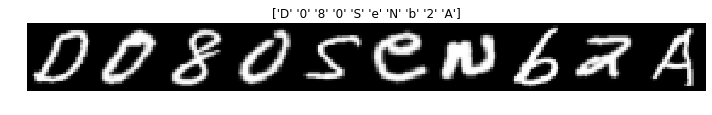

In [0]:
dataset_name = 'emnist'
batch_size = 32

[train_dataset, eval_dataset], datasets_info = tfds.load(
    name=dataset_name,
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
    shuffle_files=True)

def _preprocess(image, label):
  image = tf.cast(image, dtype=tf.float32) / 255.
  if dataset_name == 'emnist':
    image = tf.transpose(image, perm=[1, 0, 2])
  label = tf.cast(label, dtype=tf.int32)
  return image, label

train_size = datasets_info.splits['train'].num_examples
eval_size = datasets_info.splits['test'].num_examples
num_classes = datasets_info.features['label'].num_classes
image_shape = datasets_info.features['image'].shape

if dataset_name == 'emnist':
  import string
  yhuman = np.array(list(string.digits +
                         string.ascii_uppercase +
                         string.ascii_lowercase))
else:
  yhuman = np.range(num_classes).astype(np.int32)

if True:
  orig_train_size = train_size
  train_size = int(10e3)
  train_dataset = train_dataset.shuffle(orig_train_size // 7).repeat(1).take(train_size)

train_dataset = tfn.util.tune_dataset(
    train_dataset,
    batch_size=batch_size,
    shuffle_size=int(train_size  / 7),
    preprocess_fn=_preprocess)

if True:
  orig_eval_size = eval_size
  eval_size = int(10e3)
  eval_dataset = eval_dataset.shuffle(orig_eval_size // 7).repeat(1).take(eval_size)

eval_dataset = tfn.util.tune_dataset(
    eval_dataset,
    repeat_count=None,
    preprocess_fn=_preprocess)

x, y = next(iter(eval_dataset.batch(10)))
tfn.util.display_imgs(x, yhuman[y.numpy()]);

### 3  Define Model

In [0]:
#@title Optional Custom Posterior
def make_posterior(
    kernel_shape,
    bias_shape,
    dtype=tf.float32,
    kernel_initializer=None,
    bias_initializer=None,
    kernel_name='posterior_kernel',
    bias_name='posterior_bias'):
  if kernel_initializer is None:
    kernel_initializer = tf.initializers.glorot_uniform()
  if bias_initializer is None:
    bias_initializer = tf.zeros
  make_loc = lambda shape, init, name: tf.Variable(  # pylint: disable=g-long-lambda
      init(shape, dtype=dtype),
      name=name + '_loc')
  make_scale = lambda shape, name: tfp.util.TransformedVariable(  # pylint: disable=g-long-lambda
      tf.fill(shape, tf.constant(0.01, dtype)),
      tfb.Chain([tfb.Shift(1e-5), tfb.Softplus()]),
      name=name + '_scale')
  return tfd.JointDistributionSequential([
      tfd.Independent(
          tfd.Normal(loc=make_loc(kernel_shape, kernel_initializer, kernel_name),
                     scale=make_scale(kernel_shape, kernel_name)),
          reinterpreted_batch_ndims=prefer_static.size(kernel_shape),
          name=kernel_name),
      tfd.Independent(
          tfd.Normal(loc=make_loc(bias_shape, bias_initializer, bias_name),
                     scale=make_scale(bias_shape, bias_name)),
          reinterpreted_batch_ndims=prefer_static.size(bias_shape),
          name=bias_name),
  ])

In [0]:
#@title Optional Custom Prior
def make_prior(
    kernel_shape,
    bias_shape,
    dtype=tf.float32,
    kernel_initializer=None,  # pylint: disable=unused-argument
    bias_initializer=None,  # pylint: disable=unused-argument
    kernel_name='prior_kernel',
    bias_name='prior_bias'):
  k = tfd.MixtureSameFamily(
      tfd.Categorical(tf.zeros(3, dtype)),
      tfd.StudentT(
          df=[1,1.,1.], loc=[0,3,-3], scale=tf.constant([1, 10, 10], dtype)))
          #df=[0.5, 1., 1.], loc=[0, 2, -2], scale=tf.constant([0.25, 5, 5], dtype)))
  b = tfd.Normal(0, tf.constant(1000, dtype))
  return tfd.JointDistributionSequential([
      tfd.Sample(k, kernel_shape, name=kernel_name),
      tfd.Sample(b, bias_shape, name=bias_name),
  ]) 

In [0]:
max_pool = tf.keras.layers.MaxPooling2D(  # Has no tf.Variables.
    pool_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    data_format='channels_last')

def batchnorm(axis):
  def fn(x):
    m = tf.math.reduce_mean(x, axis=axis, keepdims=True)
    v = tf.math.reduce_variance(x, axis=axis, keepdims=True)
    return (x - m) / tf.math.sqrt(v)
  return fn

maybe_batchnorm = batchnorm(axis=[-4, -3, -2])
# maybe_batchnorm = lambda x: x

bnn = tfn.Sequential([
  lambda x: 2. * tf.cast(x, tf.float32) - 1.,  # Center.
  tfn.ConvolutionVariationalReparameterization(
      input_size=1,
      output_size=8,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      penalty_weight=1 / train_size,
      # penalty_weight=1e2 / train_size,  # Layer specific "beta".
      # make_posterior_fn=make_posterior,
      # make_prior_fn=make_prior,
      name='conv1'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  tfn.ConvolutionVariationalReparameterization(
      input_size=8,
      output_size=16,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      penalty_weight=1 / train_size,
      # penalty_weight=1e2 / train_size,  # Layer specific "beta".
      # make_posterior_fn=make_posterior,
      # make_prior_fn=make_prior,
      name='conv2'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  max_pool,  # [28, 28, 8] -> [14, 14, 8]
  tfn.ConvolutionVariationalReparameterization(
      input_size=16,
      output_size=32,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      penalty_weight=1 / train_size,
      # penalty_weight=1e2 / train_size,  # Layer specific "beta".
      # make_posterior_fn=make_posterior,
      # make_prior_fn=make_prior,
      name='conv3'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  max_pool,  # [14, 14, 16] -> [7, 7, 16]
  tfn.util.flatten_rightmost(ndims=3),
  tfn.AffineVariationalReparameterizationLocal(
      input_size=7 * 7 * 32,
      output_size=num_classes - 1,
      penalty_weight=1. / train_size,
      # make_posterior_fn=make_posterior,
      # make_prior_fn=make_prior,
      name='affine1'),
  tfb.Pad(),
  lambda x: tfd.Categorical(logits=x, dtype=tf.int32),   
], name='BNN')

# bnn_eval = tfn.Sequential([l for l in bnn.layers if l is not maybe_batchnorm],
#                           name='bnn_eval')
bnn_eval = bnn

print(bnn.summary())

=== BNN ==================================================
  SIZE SHAPE                TRAIN NAME                                    
   200 [5, 5, 1, 8]         True  posterior_kernel_loc:0                  
   200 [5, 5, 1, 8]         True  posterior_kernel_scale:0                
     8 [8]                  True  posterior_bias_loc:0                    
     8 [8]                  True  posterior_bias_scale:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_loc:0                  
  3200 [5, 5, 8, 16]        True  posterior_kernel_scale:0                
    16 [16]                 True  posterior_bias_loc:0                    
    16 [16]                 True  posterior_bias_scale:0                  
 12800 [5, 5, 16, 32]       True  posterior_kernel_loc:0                  
 12800 [5, 5, 16, 32]       True  posterior_kernel_scale:0                
    32 [32]                 True  posterior_bias_loc:0                    
    32 [32]                 True  posteri

### 4  Loss / Eval

In [0]:
def compute_loss_bnn(x, y, beta=1., is_eval=False):
  d = bnn_eval(x) if is_eval else bnn(x)
  nll = -tf.reduce_mean(d.log_prob(y), axis=-1)
  kl = bnn.extra_loss
  loss = nll + beta * kl
  return loss, (nll, kl), d

In [0]:
train_iter_bnn = iter(train_dataset)

def train_loss_bnn():
  x, y = next(train_iter_bnn)
  loss, (nll, kl), _ = compute_loss_bnn(x, y)
  return loss, (nll, kl)

opt_bnn = tf.optimizers.Adam(learning_rate=0.003)
 
fit_bnn = tfn.util.make_fit_op(
    train_loss_bnn,
    opt_bnn,
    bnn.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs))

In [0]:
#@title Eval Helpers
def all_categories(d):
  num_classes = tf.shape(d.logits_parameter())[-1]
  batch_ndims = tf.size(d.batch_shape_tensor())
  expand_shape = tf.pad(
      [num_classes], paddings=[[0, batch_ndims]], constant_values=1)
  return tf.reshape(tf.range(num_classes, dtype=d.dtype), expand_shape)


def rollaxis(x, shift):
  return tf.transpose(x, tf.roll(tf.range(tf.rank(x)), shift=shift, axis=0))


def compute_eval_stats(y, d, threshold=None):
  # Assume we have evidence `x`, targets `y`, and model function `dnn`.

  all_pred_log_prob = tf.math.log_softmax(d.logits, axis=-1)
  yhat = tf.argmax(all_pred_log_prob, axis=-1)
  pred_log_prob = tf.reduce_max(all_pred_log_prob, axis=-1)

  # all_pred_log_prob = d.log_prob(all_categories(d))
  # yhat = tf.argmax(all_pred_log_prob, axis=0)
  # pred_log_prob = tf.reduce_max(all_pred_log_prob, axis=0)

  # Alternative #1:
  #   all_pred_log_prob = rollaxis(all_pred_log_prob, shift=-1)
  #   pred_log_prob, yhat = tf.math.top_k(all_pred_log_prob, k=1, sorted=False)

  # Alternative #2:
  #   yhat = tf.argmax(all_pred_log_prob, axis=0)
  #   pred_log_prob = tf.gather(rollaxis(all_pred_log_prob, shift=-1),
  #                             yhat,
  #                             batch_dims=len(d.batch_shape))

  if threshold is not None:
    keep = pred_log_prob > tf.math.log(threshold)
    pred_log_prob = tf.boolean_mask(pred_log_prob, keep)
    yhat = tf.boolean_mask(yhat, keep)
    y = tf.boolean_mask(y, keep)

  hit = tf.equal(y, tf.cast(yhat, y.dtype))
  avg_acc = tf.reduce_mean(tf.cast(hit, tf.float32), axis=-1)

  num_buckets = 10
  (
    avg_calibration_error,
    acc,
    conf,
    cnt,
    edges,
    bucket,
  ) = tf.cond(tf.size(y) > 0,
              lambda: tfp.stats.expected_calibration_error_quantiles(
                  hit,
                  pred_log_prob,
                  num_buckets=num_buckets,
                  log_space_buckets=True),
              lambda: (tf.constant(np.nan),
                       tf.fill([num_buckets], np.nan),
                       tf.fill([num_buckets], np.nan),
                       tf.fill([num_buckets], np.nan),
                       tf.fill([num_buckets + 1], np.nan),
                       tf.constant([], tf.int64)))
  return avg_acc, avg_calibration_error, (acc, conf, cnt, edges, bucket)

In [0]:
eval_iter_bnn = iter(eval_dataset.batch(2000).repeat())

@tfn.util.tfcompile
def eval_bnn(threshold=None, num_inferences=5):
  x, y = next(eval_iter_bnn)
  loss, (nll, kl), d = compute_loss_bnn(x, y, is_eval=True)
  if num_inferences > 1:
    before_avg_predicted_log_probs = tf.map_fn(
      lambda _: tf.math.log_softmax(bnn(x).logits, axis=-1),
      elems=tf.range(num_inferences),
      dtype=loss.dtype)
    d = tfd.Categorical(logits=tfp.math.reduce_logmeanexp(
        before_avg_predicted_log_probs, axis=0))
  avg_acc, avg_calibration_error, (acc, conf, cnt, edges, bucket) = \
      compute_eval_stats(y, d, threshold=threshold)
  n = tf.reduce_sum(cnt, axis=0)
  return loss, (nll, kl, avg_acc, avg_calibration_error, n)

### 5  Train

In [0]:
DEBUG_MODE = False
tf.config.experimental_run_functions_eagerly(DEBUG_MODE)

In [0]:
num_train_epochs = 2.  # @param { isTemplate: true}
num_evals = 50         # @param { isTemplate: true

dur_sec = dur_num = 0
num_train_steps = int(num_train_epochs * train_size)
for i in range(num_train_steps):
  start = time.time()
  trn_loss, (trn_nll, trn_kl), g = fit_bnn()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % int(num_train_steps / num_evals) == 0 or i == num_train_steps - 1:
    tst_loss, (tst_nll, tst_kl, tst_acc, tst_ece, tst_tot) = eval_bnn()
    f, x = zip(*[
        ('it:{:5}', opt_bnn.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('tst_acc:{:6.4f}', tst_acc),
        ('tst_ece:{:6.4f}', tst_ece),
        ('tst_tot:{:5}', tst_tot),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   bnn.save('/tmp/bnn.npz')

it:    1   ms/it:5862.5939   tst_acc:0.0845   tst_ece:0.2995   tst_tot:2000.0   trn_loss:58.9386   tst_loss:59.8447   tst_nll:6.1577   tst_kl:53.6870   sum_norm_grad:20.2655
it:  401   ms/it:4.3082   tst_acc:0.7235   tst_ece:0.0819   tst_tot:2000.0   trn_loss:42.1540   tst_loss:42.5749   tst_nll:1.1286   tst_kl:41.4463   sum_norm_grad:5.1660
it:  801   ms/it:4.2911   tst_acc:0.7160   tst_ece:0.0800   tst_tot:2000.0   trn_loss:31.7853   tst_loss:32.0219   tst_nll:1.8001   tst_kl:30.2218   sum_norm_grad:8.0951
it: 1201   ms/it:4.1917   tst_acc:0.7480   tst_ece:0.0325   tst_tot:2000.0   trn_loss:24.9088   tst_loss:24.4505   tst_nll:2.4974   tst_kl:21.9532   sum_norm_grad:9.7074
it: 1601   ms/it:3.9633   tst_acc:0.7250   tst_ece:0.0379   tst_tot:2000.0   trn_loss:18.6694   tst_loss:21.0958   tst_nll:3.5440   tst_kl:17.5518   sum_norm_grad:5.8497
it: 2001   ms/it:3.9557   tst_acc:0.7295   tst_ece:0.0424   tst_tot:2000.0   trn_loss:20.0331   tst_loss:19.6677   tst_nll:3.9847   tst_kl:15.6830

### 6  Evaluate

In [0]:
#@title More Eval Helpers
@tfn.util.tfcompile
def compute_log_probs_bnn(x, num_inferences):
  lp = tf.map_fn(lambda _: tf.math.log_softmax(bnn_eval(x).logits, axis=-1),
                 elems=tf.range(num_inferences),
                 dtype=tf.float32)
  log_mean_prob = tfp.math.reduce_logmeanexp(lp, axis=0)
  # ovr = "one vs rest"
  log_avg_std_ovr_prob = tfp.math.reduce_logmeanexp(lp + tf.math.log1p(-lp), axis=0)
  #log_std_prob = 0.5 * tfp.math.log_sub_exp(log_mean2_prob, log_mean_prob * 2.)
  tiny_ = np.finfo(lp.dtype.as_numpy_dtype).tiny
  log_std_prob = 0.5 * tfp.math.reduce_logmeanexp(
      2 * tfp.math.log_sub_exp(lp + tiny_, log_mean_prob),
      axis=0)
  return log_mean_prob, log_std_prob, log_avg_std_ovr_prob 

num_inferences = 50
num_chunks = 10

eval_iter_bnn = iter(eval_dataset.batch(eval_size // num_chunks))

@tfn.util.tfcompile
def all_eval_labels_and_log_probs_bnn():
  def _inner(_):
    x, y = next(eval_iter_bnn)
    return x, y, compute_log_probs_bnn(x, num_inferences)
  x, y, (log_probs, log_std_probs, log_avg_std_ovr_prob) = tf.map_fn(
      _inner,
      elems=tf.range(num_chunks),
      dtype=(tf.float32, tf.int32,) + ((tf.float32,) * 3,))
  return (
      tf.reshape(x, (-1,) + image_shape),
      tf.reshape(y, [-1]),
      tf.reshape(log_probs, [-1, num_classes]),
      tf.reshape(log_std_probs, [-1, num_classes]),
      tf.reshape(log_avg_std_ovr_prob, [-1, num_classes]),
  )

(
   x_, y_,
   log_probs_, log_std_probs_,
   log_avg_std_ovr_prob_,
) = all_eval_labels_and_log_probs_bnn()

In [0]:
#@title Run Eval
x, y, log_probs, log_std_probs, log_avg_std_ovr_prob = (
    x_, y_, log_probs_, log_std_probs_, log_avg_std_ovr_prob_)

yhat = tf.argmax(log_probs, axis=-1)
max_log_probs = tf.gather(log_probs, yhat, batch_dims=1)
max_log_std_probs = tf.gather(log_std_probs, yhat, batch_dims=1)
max_log_avg_std_ovr_prob = tf.gather(log_avg_std_ovr_prob, yhat, batch_dims=1)

# Sort by ascending confidence.
score = max_log_probs                       # Mean
#score = -max_log_std_probs                 # 1 / Sigma
#score = max_log_probs - max_log_std_probs  # Mean / Sigma
#score = abs(tf.math.expm1(max_log_std_probs - (max_log_probs + tf.math.log1p(-max_log_probs))))

idx = tf.argsort(score)
score = tf.gather(score, idx)
x = tf.gather(x, idx)
y = tf.gather(y, idx)
yhat = tf.gather(yhat, idx)
hit = tf.cast(tf.equal(y, tf.cast(yhat,y.dtype)), tf.int32)
log_probs = tf.gather(log_probs, idx)
max_log_probs = tf.gather(max_log_probs, idx)
log_std_probs = tf.gather(log_std_probs, idx)
max_log_std_probs = tf.gather(max_log_std_probs, idx)
log_avg_std_ovr_prob = tf.gather(log_avg_std_ovr_prob, idx)
max_log_avg_std_ovr_prob = tf.gather(max_log_avg_std_ovr_prob, idx)

d = tfd.Categorical(logits=log_probs)

max_log_probs = tf.reduce_max(log_probs, axis=-1)

keep = tf.range(500,eval_size)
#threshold = 0.95;
# keep = tf.where(max_log_probs > tf.math.log(threshold))[..., 0]

x_keep = tf.gather(x, keep)
y_keep = tf.gather(y, keep)
log_probs_keep = tf.gather(log_probs, keep)
yhat_keep = tf.gather(yhat, keep)
d_keep = tfd.Categorical(logits=log_probs_keep)

(
    avg_acc, ece,
    (acc, conf, cnt, edges, bucket),
) = tfn.util.tfcompile(lambda: compute_eval_stats(y, d))()

(
    avg_acc_keep, ece_keep,
    (acc_keep, conf_keep, cnt_keep, edges_keep, bucket_keep),
) = tfn.util.tfcompile(lambda: compute_eval_stats(y_keep, d_keep))()



In [0]:
print('Accurary (all)     : {}'.format(avg_acc))
print('Accurary (certain) : {}'.format(avg_acc_keep))
print('ECE      (all)     : {}'.format(ece))
print('ECE      (certain) : {}'.format(ece_keep))
print('Number undecided: {}'.format(eval_size - tf.size(keep)))

Accurary (all)     : 0.8123999834060669
Accurary (certain) : 0.8370526432991028
ECE      (all)     : 0.015362780541181564
ECE      (certain) : 0.01939529925584793
Number undecided: 500


Most uncertain:


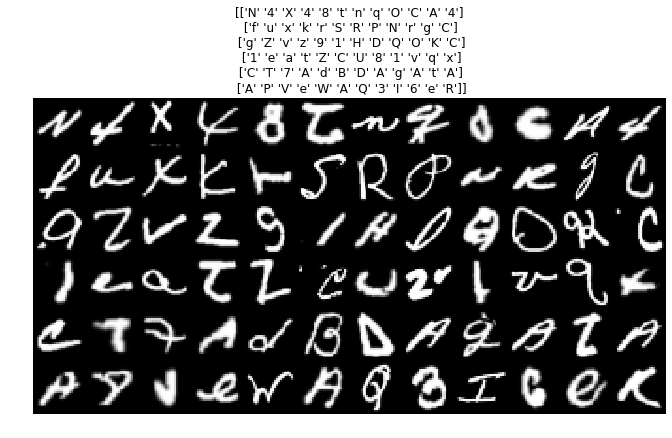

[[0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [1 1 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 1 0 0 0 0]]
[['8' 'W' 'y' 'K' '0' 'z' 'w' 'P' 'O' 'e' 'k' '2']
 ['P' 'a' 'x' 'L' 'H' 'S' 'R' 'g' 'e' 'e' '1' 'C']
 ['0' '2' 'V' '2' '8' 'V' 'A' 'W' 'Q' '0' 'x' '1']
 ['1' 'e' 'U' 'T' 'z' 'L' 'C' 'z' 'h' 'v' '7' 'F']
 ['e' 'T' '2' 'n' 'd' 'z' '5' 'n' 'z' 'O' 'I' 'A']
 ['N' 'p' 'I' 'w' 'V' 'A' 'q' '3' 't' 'z' '8' 'r']]


In [0]:
print('Most uncertain:')
ss = (6,12); n = np.prod(ss); s = ss+image_shape
tfn.util.display_imgs(
    tf.reshape(x[:n], s),
    yhuman[tf.reshape(y[:n], ss).numpy()])
print(tf.reshape(hit[:n], ss).numpy())
print(yhuman[tf.reshape(yhat[:n], ss).numpy()])

Least uncertain:


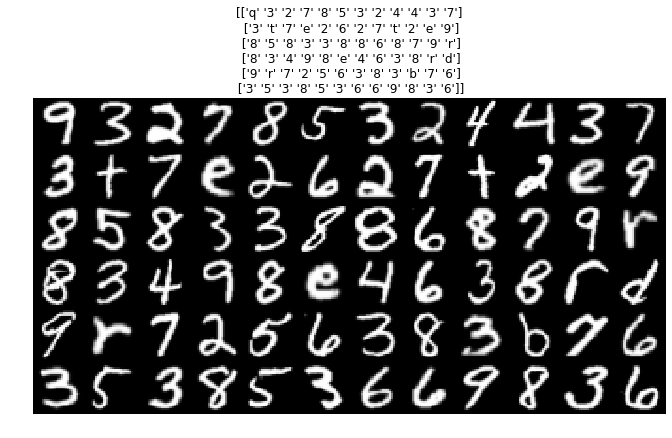

[[0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]]
[['9' '3' '2' '7' '8' '5' '3' '2' '4' '4' '3' '7']
 ['3' 't' '7' 'e' '2' '6' '2' '7' 't' '2' 'e' '9']
 ['8' '5' '8' '3' '3' '8' '8' '6' '8' '7' '9' 'r']
 ['8' '3' '4' '9' '8' 'e' '4' '6' '3' '8' 'r' 'd']
 ['9' 'r' '7' '2' '5' '6' '3' '8' '3' 'b' '7' '6']
 ['3' '5' '3' '8' '5' '3' '6' '6' '9' '8' '3' '6']]


In [0]:
print('Least uncertain:')
tfn.util.display_imgs(
    tf.reshape(x[-n:], s),
    yhuman[tf.reshape(y[-n:], ss).numpy()])
print(tf.reshape(hit[-n:], ss).numpy())
print(yhuman[tf.reshape(yhat[-n:], ss).numpy()])

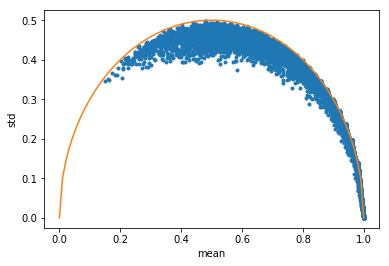

In [0]:
a = tf.math.exp(max_log_probs)
b = tf.math.exp(max_log_std_probs)
plt.plot(a, b, '.', label='observed');
#sns.jointplot(a.numpy(), b.numpy())

plt.xlabel('mean');
plt.ylabel('std');
p = tf.linspace(0.,1,100)
plt.plot(p, tf.math.sqrt(p * (1 - p)), label='theoretical');

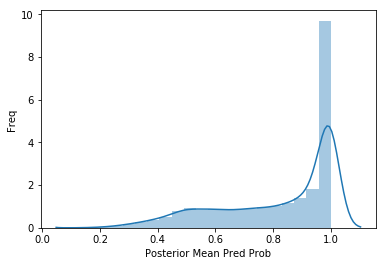

In [0]:
b = max_log_probs
# b = tf.boolean_mask(b, b < 0.)
sns.distplot(tf.math.exp(b).numpy(), bins=20);
plt.xlabel('Posterior Mean Pred Prob');
plt.ylabel('Freq');

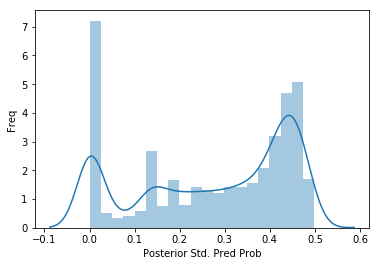

In [0]:
b = max_log_std_probs
tiny_ = np.finfo(b.dtype.as_numpy_dtype).tiny
b = tf.boolean_mask(b, b > tf.math.log(tiny_))
sns.distplot(tf.math.exp(b).numpy(), bins=20);
plt.xlabel('Posterior Std. Pred Prob');
plt.ylabel('Freq');

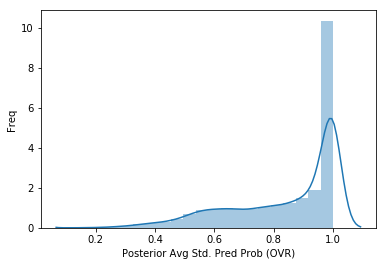

In [0]:
b = max_log_avg_std_ovr_prob
sns.distplot(tf.math.exp(b).numpy(), bins=20);
plt.xlabel('Posterior Avg Std. Pred Prob (OVR)');
plt.ylabel('Freq');

In [0]:
#@title Avg One-vs-Rest AUC
try:
  bnn_auc = sklearn_metrics.roc_auc_score(
      y_keep,
      log_probs_keep,
      average='macro',
      multi_class='ovr')  
  print('Avg per class AUC:\n{}'.format(bnn_auc))
except TypeError:
  bnn_auc = np.array([
    sklearn_metrics.roc_auc_score(tf.equal(y_keep, i), log_probs_keep[:, i])
    for i in range(num_classes)])
  print('Avg per class AUC:\n{}'.format(bnn_auc.mean()))

Avg per class AUC:
0.9909210101534324


### 7 Appendix: Compare against DNN

In [0]:
max_pool = tf.keras.layers.MaxPooling2D(  # Has no tf.Variables.
    pool_size=(2, 2),
    strides=(2, 2),
    padding='SAME',
    data_format='channels_last')

maybe_batchnorm = batchnorm(axis=[-4, -3, -2])
# maybe_batchnorm = lambda x: x

dnn = tfn.Sequential([
  lambda x: 2. * tf.cast(x, tf.float32) - 1.,  # Center.
  tfn.Convolution(
      input_size=1,
      output_size=8,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      name='conv1'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  tfn.Convolution(
      input_size=8,
      output_size=16,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      name='conv1'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  max_pool,  # [28, 28, 8] -> [14, 14, 8]
  tfn.Convolution(
      input_size=16,
      output_size=32,
      filter_shape=5,
      padding='SAME',
      init_kernel_fn=tf.initializers.he_uniform(),
      name='conv2'),
  maybe_batchnorm,
  tf.nn.leaky_relu,
  max_pool,  # [14, 14, 16] -> [7, 7, 16]
  tfn.util.flatten_rightmost(ndims=3),
  tfn.Affine(
      input_size=7 * 7 * 32,
      output_size=num_classes - 1,
      name='affine1'),
  tfb.Pad(),
  lambda x: tfd.Categorical(logits=x, dtype=tf.int32),   
], name='DNN')

# dnn_eval = tfn.Sequential([l for l in dnn.layers if l is not maybe_batchnorm],
#                           name='dnn_eval')
dnn_eval = dnn

print(dnn.summary())

=== DNN ==================================================
  SIZE SHAPE                TRAIN NAME                                    
     8 [8]                  True  bias:0                                  
   200 [5, 5, 1, 8]         True  kernel:0                                
    16 [16]                 True  bias:0                                  
  3200 [5, 5, 8, 16]        True  kernel:0                                
    32 [32]                 True  bias:0                                  
 12800 [5, 5, 16, 32]       True  kernel:0                                
    61 [61]                 True  bias:0                                  
 95648 [1568, 61]           True  kernel:0                                
trainable size: 111965  /  0.427 MiB  /  {float32: 111965}


In [0]:
def compute_loss_dnn(x, y, is_eval=False):
  d = dnn_eval(x) if is_eval else dnn(x)
  nll = -tf.reduce_mean(d.log_prob(y), axis=-1)
  return nll, d

In [0]:
train_iter_dnn = iter(train_dataset)

def train_loss_dnn():
  x, y = next(train_iter_dnn)
  nll, _ = compute_loss_dnn(x, y)
  return nll, None

opt_dnn = tf.optimizers.Adam(learning_rate=0.003)
 
fit_dnn = tfn.util.make_fit_op(
    train_loss_dnn,
    opt_dnn,
    dnn.trainable_variables,
    grad_summary_fn=lambda gs: tf.nest.map_structure(tf.norm, gs))

In [0]:
eval_iter_dnn = iter(eval_dataset.batch(2000).repeat())

@tfn.util.tfcompile
def eval_dnn(threshold=None):
  x, y = next(eval_iter_dnn)
  loss, d = compute_loss_dnn(x, y, is_eval=True)
  avg_acc, avg_calibration_error, _ = compute_eval_stats(
      y, d, threshold=threshold)
  return loss, (avg_acc, avg_calibration_error)

In [0]:
num_train_epochs = 2.  # @param { isTemplate: true}
num_evals = 25         # @param { isTemplate: true

dur_sec = dur_num = 0
num_train_steps = int(num_train_epochs * train_size)
for i in range(num_train_steps):
  start = time.time()
  trn_loss, _, g = fit_dnn()
  stop = time.time()
  dur_sec += stop - start
  dur_num += 1
  if i % int(num_train_steps / num_evals) == 0 or i == num_train_steps - 1:
    tst_loss, (tst_acc, tst_ece) = eval_dnn()
    f, x = zip(*[
        ('it:{:5}', opt_dnn.iterations),
        ('ms/it:{:6.4f}', dur_sec / max(1., dur_num) * 1000.),
        ('tst_acc:{:6.4f}', tst_acc),
        ('tst_ece:{:6.4f}', tst_ece),
        ('trn_loss:{:6.4f}', trn_loss),
        ('tst_loss:{:6.4f}', tst_loss),
        ('tst_nll:{:6.4f}', tst_nll),
        ('tst_kl:{:6.4f}', tst_kl),
        ('sum_norm_grad:{:6.4f}', sum(g)),

    ])
    print('   '.join(f).format(*[getattr(x_, 'numpy', lambda: x_)()
                                 for x_ in x]))
    sys.stdout.flush()
    dur_sec = dur_num = 0
  # if i % 1000 == 0 or i == maxiter - 1:
  #   dnn.save('/tmp/dnn.npz')

it:    1   ms/it:2054.2676   tst_acc:0.0755   tst_ece:0.2507   trn_loss:5.2464   tst_loss:4.9561   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:20.3449
it:  801   ms/it:2.6896   tst_acc:0.7210   tst_ece:0.1463   trn_loss:0.7330   tst_loss:1.2686   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:4.4537
it: 1601   ms/it:2.6657   tst_acc:0.7655   tst_ece:0.1314   trn_loss:0.7336   tst_loss:1.1220   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:5.6005
it: 2401   ms/it:2.7007   tst_acc:0.7760   tst_ece:0.1478   trn_loss:1.4435   tst_loss:1.2130   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:7.4838
it: 3201   ms/it:2.6893   tst_acc:0.7435   tst_ece:0.1654   trn_loss:0.6468   tst_loss:1.3543   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:4.9734
it: 4001   ms/it:2.6818   tst_acc:0.7510   tst_ece:0.1749   trn_loss:0.6040   tst_loss:1.4282   tst_nll:3.8186   tst_kl:11.9721   sum_norm_grad:4.1424
it: 4801   ms/it:2.6974   tst_acc:0.7630   tst_ece:0.1634   trn_loss:0.2504   tst_loss:1.5

In [0]:
#@title Run Eval
eval_iter_dnn = iter(eval_dataset.batch(eval_size))
@tfn.util.tfcompile
def compute_log_probs_dnn():
  x, y = next(eval_iter_dnn)
  lp = tf.math.log_softmax(dnn_eval(x).logits, axis=-1)
  return x, y, lp
x, y, log_probs = compute_log_probs_dnn()



max_log_probs = tf.reduce_max(log_probs, axis=-1)

idx = tf.argsort(max_log_probs)
x = tf.gather(x, idx)
y = tf.gather(y, idx)
log_probs = tf.gather(log_probs, idx)
max_log_probs = tf.gather(max_log_probs, idx)
yhat = tf.argmax(log_probs, axis=-1)
d = tfd.Categorical(logits=log_probs)
hit = tf.cast(tf.equal(y, tf.cast(yhat, y.dtype)), tf.int32)

#threshold = 1.-1e-5
#keep = tf.where(max_log_probs >= np.log(threshold))[..., 0]
keep = tf.range(500, eval_size)

x_keep = tf.gather(x, keep)
y_keep = tf.gather(y, keep)
yhat_keep = tf.gather(yhat, keep)
log_probs_keep = tf.gather(log_probs, keep)
max_log_probs_keep = tf.gather(max_log_probs, keep)
hit_keep = tf.gather(hit, keep)
d_keep = tfd.Categorical(logits=log_probs_keep)

(
    avg_acc, ece,
    (acc, conf, cnt, edges, bucket),
) = tfn.util.tfcompile(lambda: compute_eval_stats(y, d))()

(
    avg_acc_keep, ece_keep,
    (acc_keep, conf_keep, cnt_keep, edges_keep, bucket_keep),
) = tfn.util.tfcompile(lambda: compute_eval_stats(y_keep, d_keep))()

In [0]:
print('Number of examples undecided: {}'.format(eval_size - tf.size(keep)))
print('Accurary before excluding undecided ones: {}'.format(avg_acc))
print('Accurary after excluding undecided ones: {}'.format(avg_acc_keep))
print('ECE before/after.', ece.numpy(), ece_keep.numpy())

Number of examples undecided: 500
Accurary before excluding undecided ones: 0.7723999619483948
Accurary after excluding undecided ones: 0.7929473519325256
ECE before/after. 0.19434331 0.19272518


Most uncertain:


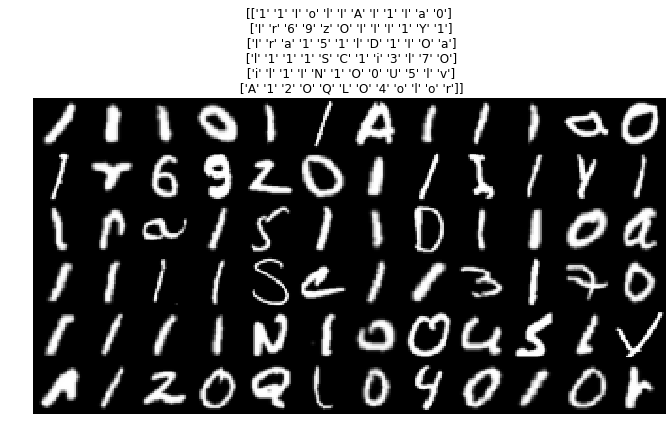

[[1 0 1 0 0 1 0 0 0 1 0 1]
 [1 1 0 1 0 0 1 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 0 1 0 1 1 0 0]
 [1 0 0 0 1 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0]]
[['1' 'i' 'I' 'O' 'I' 'I' 'R' 'l' 'I' 'I' 's' '0']
 ['I' 'r' '5' '9' 'Z' '8' 'I' '1' 'I' 'l' 'l' 'l']
 ['l' 'l' '2' '1' 'S' 'I' 'I' '8' '1' 'I' '0' '0']
 ['1' 'I' '1' 'I' 'j' 'a' '1' '1' '3' 'l' 'y' '0']
 ['i' '1' 'I' '1' 'N' 'I' '0' '0' 'u' 'I' '1' 'V']
 ['0' 'I' 'z' 'O' 'R' 'l' '0' 'y' '0' 'l' '0' 't']]


In [0]:
print('Most uncertain:')
ss = (6,12); n = np.prod(ss); s = ss+image_shape
tfn.util.display_imgs(
    tf.reshape(x[:n], s),
    yhuman[tf.reshape(y[:n], ss).numpy()])
print(tf.reshape(hit[:n], ss).numpy())
print(yhuman[tf.reshape(yhat[:n], ss).numpy()])

Least uncertain:


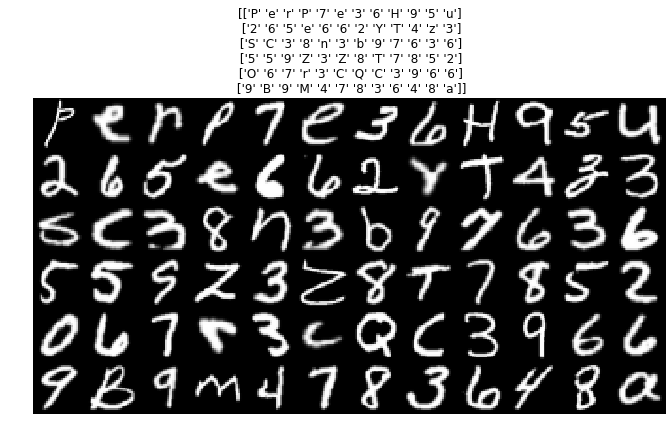

[[1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]]
[['P' 'e' 'r' 'P' '7' 'e' '3' '6' 'H' '9' '5' 'U']
 ['2' '6' '5' 'e' '6' '6' '2' 'y' 'T' '4' '2' '3']
 ['S' 'C' '3' '8' 'n' '3' 'b' '9' '7' '6' '3' '6']
 ['5' '5' '9' 'Z' '3' 'Z' '8' 'T' '7' '8' '5' '2']
 ['0' '6' '7' 'r' '3' 'C' 'Q' 'C' '3' '9' '6' '6']
 ['9' 'B' '9' 'M' '4' '7' '8' '3' '6' '4' '8' 'a']]


In [0]:
print('Least uncertain:')
tfn.util.display_imgs(
    tf.reshape(x[-n:], s),
    yhuman[tf.reshape(y[-n:], ss).numpy()])
print(tf.reshape(hit[-n:], ss).numpy())
print(yhuman[tf.reshape(yhat[-n:], ss).numpy()])

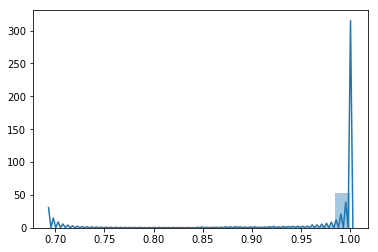

In [0]:
b = max_log_probs + tf.math.log1p(-max_log_probs); b=tf.boolean_mask(b,b<-1e-12)
sns.distplot(tf.math.exp(b).numpy(), bins=20);

In [0]:
#@title Avg One-vs-Rest AUC
try:
  dnn_auc = sklearn_metrics.roc_auc_score(
      y_keep,
      log_probs_keep,
      average='macro',
      multi_class='ovr')  
  print('Avg per class AUC:\n{}'.format(dnn_auc))
except TypeError:
  dnn_auc = np.array([
    sklearn_metrics.roc_auc_score(tf.equal(y_keep, i), log_probs_keep[:, i])
    for i in range(num_classes)])
  print('Avg per class AUC:\n{}'.format(dnn_auc.mean()))

Avg per class AUC:
0.9858841557475477
